# Clustering

For users already familiar with the clustering interface: The corresponding [API docs](../api/index_clustering.rst).

While clustering not necessarily classifies as a timeseries analysis tool, it is often used in pre-processing steps alongside dimensionality reduction tools so that dynamical models can be fitted.

In the following, the different clustering methods available are shown at the example randomly generated dots on a 2D plane.

In [1]:
# matplotlib for plotting
import matplotlib.pyplot as plt
import numpy as np 

# for example data generation
from sklearn.mixture import GaussianMixture

# create a random state with fixed seed for reproducibility
rnd = np.random.RandomState(seed=17)

# disable convergence warnings
import warnings; warnings.simplefilter('ignore')

A Gaussian mixture model object is created with 5 components. The random state is fixed and the covariance type is set to `'diag'`, meaning that covariance matrices describing the model can only be diagonal matrices.

In [2]:
n_components = 5
# create a GMM object
gmm = GaussianMixture(n_components=n_components, random_state=rnd, covariance_type='diag')

The GMM is initialized so most components have equally low weight, the means $\mu$ are drawn randomly uniform $\mu\sim \mathcal{U}([-20, 20]^2)$, and the covariance matrix diagonals are drawn from $\mathcal{U}([15, 18]^2)$.

One component is set to a very high weight (relative to the others), so that most of the samples are drawn from its corresponding Gaussian.

In [3]:
gmm.weights_ = np.array([10., 100., 10000., 10., 10.])
# weights need to form a probability distribution
gmm.weights_ /= gmm.weights_.sum()
# centers are random uniform
gmm.means_ = rnd.uniform(low=-20., high=20., size=(n_components, 2))
# same for covariance matrices
gmm.covariances_ = rnd.uniform(low=15., high=18., size=(n_components, 2))

Samples are drawn and depicted in a heatmap. The color coding is on a logarithmic scale so that the under-populated states are visible too.

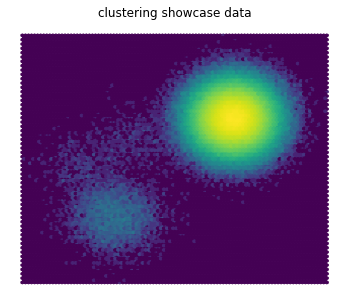

In [4]:
# generate data
samples, labels = gmm.sample(500000)
plt.figure(figsize=(6, 5))
plt.hexbin(*(samples.T), bins='log')
plt.axis('off')
plt.title('clustering showcase data');

## K-means

K-means clustering <cite data-footcite="lloyd1982least">(Lloyd, 1982)</cite> clusters the data in a way that minimizes the cost function

$$
C(S) = \sum_{i=1}^{k} \sum_{\mathbf{x}_j \in S_i} \left\| \mathbf{x}_j - \boldsymbol\mu_i \right\|^2,
$$

where $S_i$ are clusters with centers of mass $\mu_i$ and $\mathbf{x}_j$ data points associated to their clusters.

The outcome is very dependent on the initialization, in particular we offer "kmeans++" and "uniform". The latter
picks initial centers random-uniformly over the provided data set. The former tries to find an initialization
which is covering the spatial configuration of the dataset more or less uniformly.

### uniform initialization

Here, the initial set of centers $\hat\mu = \{\mu_i : i=1,\ldots,k\}$ is determined by picking points from the dataset uniformly, i.e., 
$$
\hat\mu = \{\mathbf{x}_i : i = i_1,\ldots, i_k\},
$$
where $i_1,\ldots,i_k\sim \mathcal{U}\{1,\ldots,n_\mathrm{data}\}$.

To this end, we create a [KMeans](../api/generated/deeptime.clustering.KMeans.rst#deeptime.clustering.KMeans) object. Note that that maximum number of iterations is set to zero so that the initialization can be observed.

In [5]:
from deeptime.clustering import KMeans

estimator = KMeans(
    n_clusters=100,  # place 100 cluster centers 
    init_strategy='uniform',  # uniform initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13, 
    n_jobs=8
)

The [KMeans](../api/generated/deeptime.clustering.KMeans.rst#deeptime.clustering.KMeans) object is fit (which means that in this case, only the initial centers are drawn) and with a call to [fetch_model()](../api/generated/deeptime.clustering.KMeans.rst#deeptime.clustering.KMeans.fetch_model) yields the estimated [clustering model](../api/generated/deeptime.clustering.KMeansModel.rst#deeptime.clustering.KMeansModel). The model mainly stores the estimated parameters (in this case: cluster centers) and offers convenience methods.

In [6]:
clustering = estimator.fit(samples).fetch_model()

A call to [transform()](../api/generated/deeptime.clustering.KMeansModel.rst#deeptime.clustering.KMeansModel.transform) assigns the samples to their nearest cluster center, yielding a so-called _discrete trajectory_ of integer values.

In [7]:
assignments = clustering.transform(samples)

The cluster centers and assignments can be visualized as below.

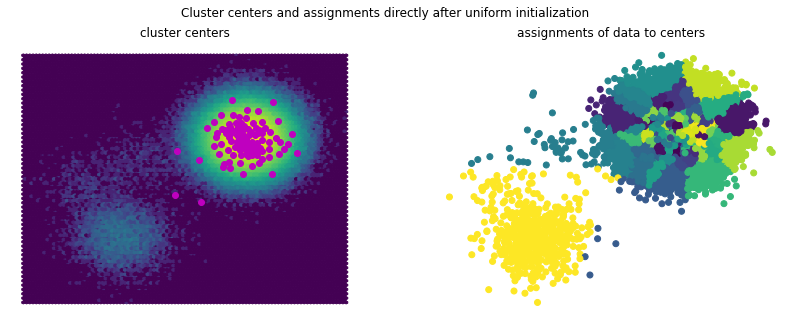

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments directly after uniform initialization')

ax1.hexbin(*(samples.T), bins='log')
ax1.scatter(*(clustering.cluster_centers.T), marker='o', c='m')
ax1.axis('off')
ax1.set_title('cluster centers')

ax2.scatter(*(samples[::10].T), c=assignments[::10])
ax2.axis('off')
ax2.set_title('assignments of data to centers');

It becomes evident that almost all of the 100 cluster centers are placed in the area of the highly populated component. This can be a disadvantage when building [Markov state models](../index_msm.rst), as here one would be interested in the transition between states and this clustering only resolves the highly populated state.

Now that initial centers are found, one can try to actually fit the model, i.e., perform the optimization of the objective function.

In [9]:
estimator.initial_centers = clustering.cluster_centers
estimator.max_iter = 5000

After having set a high-enough number of optimization steps and updating the initial centers to the ones of the previously estimated model, one can fit the samples again and obtain a new, updated model.

In [10]:
clustering_new = estimator.fit(samples).fetch_model()

Visualizing the cluster centers and assignments reveals that while the lower component is now clustered into three states, it is still only very coarsely resolved, ignoring potential internal state transitions.

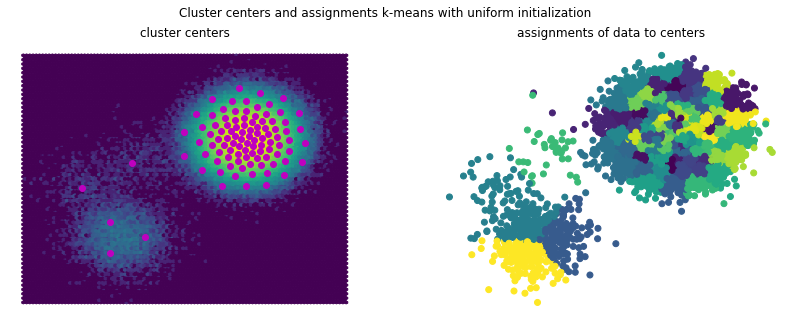

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments k-means with uniform initialization')

ax1.hexbin(*(samples.T), bins='log')
ax1.scatter(*(clustering_new.cluster_centers.T), marker='o', c='m')
ax1.axis('off')
ax1.set_title('cluster centers')

ax2.scatter(*(samples[::10].T), c=clustering_new.transform(samples)[::10])
ax2.axis('off')
ax2.set_title('assignments of data to centers')
plt.show();

Looking at the training [inertias](../api/generated/deeptime.clustering.KMeansModel.rst#deeptime.clustering.KMeansModel.inertias), i.e., the evaluation of the objective function

$$\sum_{i=1}^{k} \sum_{\mathbf{x}_j \in S_i} \left\| \mathbf{x}_j - \boldsymbol\mu_i \right\|^2,$$

one can see that convergence is starting off from a better point and also reaches a lower final inertia.

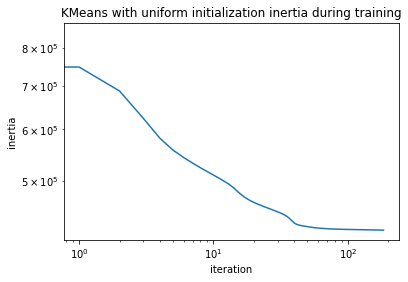

In [12]:
plt.loglog(clustering_new.inertias)
plt.xlabel("iteration")
plt.ylabel("inertia")
plt.title("KMeans with uniform initialization inertia during training");

### k-means++ initialization

Although computationally more costly than initializing the centers uniformly, kmeans++ <cite data-footcite="arthur2006k">(Arthur, 2006)</cite> initialization leads to an initial distribution under which the centers yield a better coverage of the state space.

The idea is to choose the initial cluster centers subsequently such that each chosen cluster center is not near any of the previously chosen ones. Therefore the uniform distribution is replaced by a weighted distribution that uses the squared distances to the set of already chosen centers. Roughly:

1. Take one center chosen uniformly at random from the data set.
2. Take a new center chosen at random with the probability weights 
   $$
   \frac{D(x)^2}{\sum_{x}D(x)^2},
   $$
   where $D(x)$ is the shortest distance from a datapoint $x$ to the set of already placed cluster centers.
3. If not all cluster centers have been placed, repeat step 2.

In [13]:
estimator = KMeans(
    n_clusters=100,  # place 100 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13,
    n_jobs=8
)

Having created an appropriate estimator, we can fit and fetch a clustering model.

In [14]:
clustering = estimator.fit(samples).fetch_model()

Assigning data to respective cluster centers is analogous to uniform initialization.

In [15]:
assignments = clustering.transform(samples)

Again, cluster centers and assignments can be visualized:

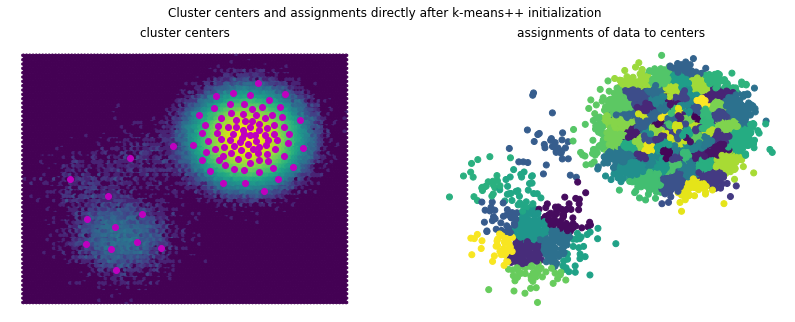

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments directly after k-means++ initialization')

ax1.hexbin(*(samples.T), bins='log')
ax1.scatter(*(clustering.cluster_centers.T), marker='o', c='m')
ax1.axis('off')
ax1.set_title('cluster centers')

ax2.scatter(*(samples[::10].T), c=assignments[::10])
ax2.axis('off')
ax2.set_title('assignments of data to centers');

When starting the k-means optimization with this set of cluster centers, the lower component of the data set is better resolved than in the uniform case. This is mostly due to the k-means optimization algorithm getting stuck in local optima. 

In [17]:
estimator.initial_centers = clustering.cluster_centers
estimator.max_iter = 5000
clustering_new = estimator.fit(samples).fetch_model()

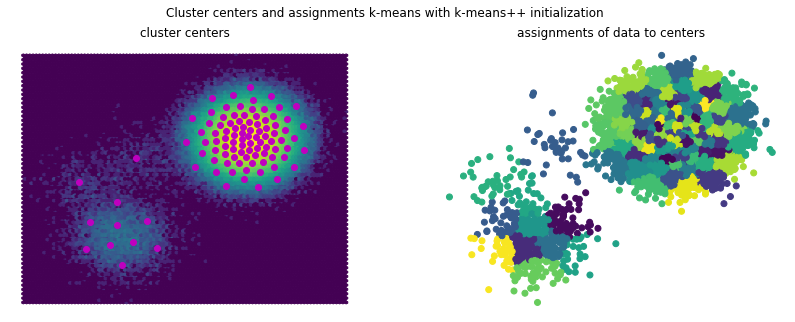

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments k-means with k-means++ initialization')

ax1.hexbin(*(samples.T), bins='log')
ax1.scatter(*(clustering_new.cluster_centers.T), marker='o', c='m')
ax1.axis('off')
ax1.set_title('cluster centers')

ax2.scatter(*(samples[::10].T), c=clustering_new.transform(samples)[::10])
ax2.axis('off')
ax2.set_title('assignments of data to centers');

Looking at the training inertias one can see that convergence is starting off from a better point and also reaches a lower final inertia.

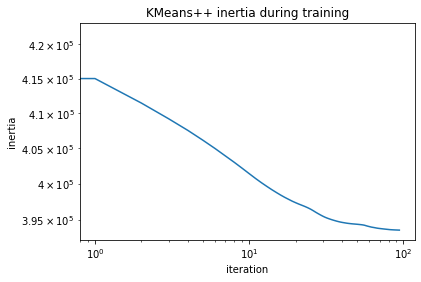

In [19]:
plt.loglog(clustering_new.inertias)
plt.xlabel("iteration")
plt.ylabel("inertia")
plt.title("KMeans++ inertia during training");

## Mini-batch k-means

If the data set at hand is too large to have it in memory at once but still a clustering should be performed, [mini-batch k-means](../api/generated/deeptime.clustering.MiniBatchKMeans.rst#deeptime.clustering.MiniBatchKMeans) <cite data-footcite="sculley2010web">(Sculley, 2010)</cite> can be used. Similarly to ordinary k-means, it needs a set of initial centers and then tries to minimize the k-means objective. However, it does so in a streaming fashion, i.e., the model gets constantly fed with new / different data.

This data can come from a large data source and/or be randomly sampled. Memory consumption is therefore lower and the algorithm itself can converge quicker. However, the quality of the obtained results is reduced.

In [20]:
from deeptime.clustering import MiniBatchKMeans

estimator = MiniBatchKMeans(
    n_clusters=100,  # number of cluster centers
    max_iter=100,  # maximum number of passes over full dataset when calling fit()
    batch_size=327,  # sample size when drawing samples in fit()
    init_strategy='kmeans++',  # initialization strategy
    n_jobs=8
)

In [21]:
clustering = estimator.fit(samples).fetch_model()

While calling `fit(samples)` makes passes over the whole data, the model can also be [partially fitted](../api/generated/deeptime.clustering.MiniBatchKMeans.rst#deeptime.clustering.MiniBatchKMeans.partial_fit) and therefore trained in an online fashion.

In [22]:
for _ in range(10000):
    estimator.partial_fit(samples[:100])

Once finished, the clustering model can be obtained as usual:

In [23]:
clustering = estimator.fetch_model()

## Regular space clustering

Regular space clustering <cite data-footcite="prinz2011markov">(Prinz, 2011)</cite> assigns data objects in such a way, that cluster centers are at least in distance of $d_\mathrm{min}$ to each other according to the given metric. The assignment of data objects to cluster centers is performed by Voronoi partioning.

This clustering algorithm is very similar to Hartigan’s leader algorithm <cite data-footcite="hartigan1975clustering">(Hartigan, 1975)</cite>. It consists of two passes through the data. Initially, the first data point is added to the list of centers. For every subsequent data point, if it has a greater distance than $d_\mathrm{min}$ from every center, it also becomes a center. In the second pass, a Voronoi discretization with the computed centers is used to partition the data.

To perform regular space clustering, a corresponding [RegularSpace](../api/generated/deeptime.clustering.RegularSpace.rst#deeptime.clustering.RegularSpace) estimator can be created: 

In [24]:
from deeptime.clustering import RegularSpace

estimator = RegularSpace(
    dmin=3,  # minimum distance between cluster centers
    max_centers=500,  # maximum number of cluster centers
    n_jobs=8
)

Now a [regular clustering model](../api/generated/deeptime.clustering.ClusterModel.rst#deeptime.clustering.ClusterModel) can be fitted.

In [25]:
model = estimator.fit(samples).fetch_model()

Plotting the data assignments and cluster centers reveals that a nice partition of the space can be achieved. This however is very dependent on the hyperparameters $d_\mathrm{min}$ and `max_centers`, which in higher dimensions can be difficult to choose and assess.

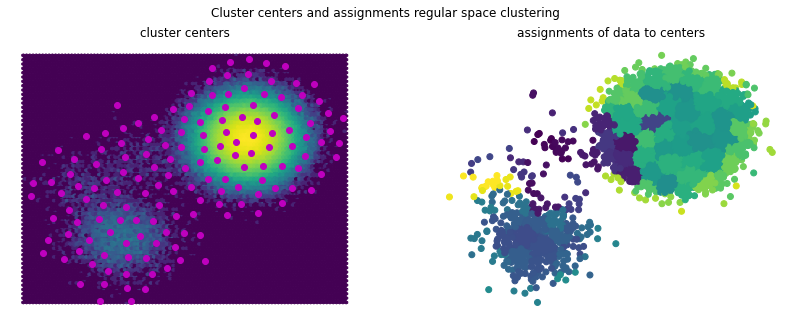

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments regular space clustering')

ax1.hexbin(*(samples.T), bins='log')
ax1.scatter(*(model.cluster_centers.T), marker='o', c='m')
ax1.axis('off')
ax1.set_title('cluster centers')

ax2.scatter(*(samples[::10].T), c=model.transform(samples)[::10])
ax2.axis('off')
ax2.set_title('assignments of data to centers');

## Box discretization

While not suitable for very high dimensions sometimes it is also useful to just discretize space into regular boxes. This can be achieved with the [BoxDiscretization](../api/generated/deeptime.clustering.BoxDiscretization.rst).

In [27]:
from deeptime.clustering import BoxDiscretization

estimator = BoxDiscretization(
    dim=2,  # the number of dimensions the data lives in
    n_boxes=[7, 6]  # number of boxes per axis (can also be single int for all axes)
)
model = estimator.fit(samples).fetch_model()

We now can visualize the data over the centers. For this purpose we shuffle the cluster centers in the model to get a better color map separation.

In [28]:
np.random.shuffle(model.cluster_centers)

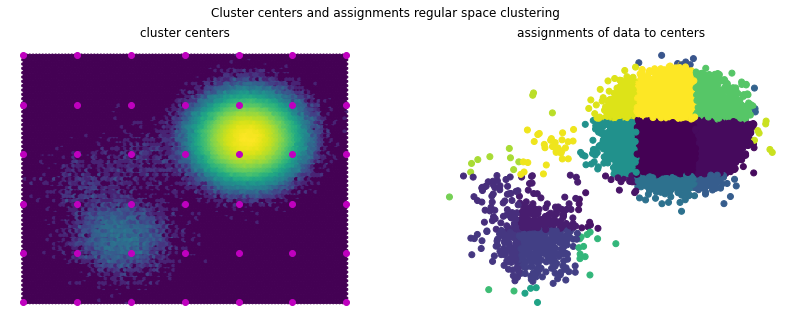

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments regular space clustering')

ax1.hexbin(*(samples.T), bins='log')
ax1.scatter(*(model.cluster_centers.T), marker='o', c='m')
ax1.axis('off')
ax1.set_title('cluster centers')

ax2.scatter(*(samples[::10].T), c=model.transform(samples)[::10])
ax2.axis('off')
ax2.set_title('assignments of data to centers');

## Defining a custom metric (advanced)

Everything until now used a Euclidean metric $d(x,y) = \sqrt{\sum_i (x_i - y_i)^2}$ for clustering. It is however possible, to define custom metrics. As the metric evaluation is performance-critical, custom metrics are only supported by implementing a C++ interface and exporting it to Python.

Such an implementation, here at the example of the maximum metric (or Chebyshev distance, induced by the maximum norm $\|\mathbf{x}\|_\infty := \max\{|\mathbf{x}_1|,\ldots,|\mathbf{x}_d|\}$), can look like

```cpp
#include "metric.h"

class MaximumMetric : public Metric {
public:

    double compute_squared_d(const double* xs, const double* ys, std::size_t dim) const override {
        return _compute(xs, ys, dim);
    }
    float compute_squared_f(const float* xs, const float* ys, std::size_t dim) const override {
        return _compute(xs, ys, dim);
    }
private:
    template<typename T>
    T _compute(const T* xs, const T* ys, std::size_t dim) const {
        T result = 0.0;
        for (size_t i = 0; i < dim; ++i) {
            auto d = std::abs(xs[i] - ys[i]);
            if (d > result) {
                result = d;
            }
        }
        return result*result;
    }
};

PYBIND11_MODULE(custom_metric, module) {
    py::class_<MaximumMetric, Metric>(module, "MaximumMetric").def(py::init<>());
}
```

The deeptime required include directories can be obtained by a call to `deeptime.capi_includes()`. Here, the class is exported to Python with with [pybind11](https://github.com/pybind/pybind11) in the same `cpp` file.

Setting up compilation through, e.g., setuptools can be performed like follows:

```python
import setuptools
import pybind11
import deeptime

setuptools.setup(
    name='custom_metric',
    packages=setuptools.find_packages(),
    version='0.1',
    ext_modules=[
        setuptools.Extension(
            name='custom_metric',
            sources=['bindings.cpp'],
            language='c++',
            include_dirs=deeptime.capi_includes() + [pybind11.get_include()],
            extra_compile_args=['-fopenmp'],  # OpenMP support, optional
            extra_link_args=['-lgomp']  # OpenMP support, optional
        )
    ]
)
```

After successful compilation (`python setup.py develop` or `install`), the metric can be used via

```python
import deeptime
import custom_metric
obs = deeptime.data.ellipsoids().observations(1000)

deeptime.clustering.metrics.register('max', custom_metric.MaximumMetric)
c = deeptime.clustering.KMeans(n_clusters=5, metric='max')
c.fit(obs)
```

It is important to first import `deeptime`, so that the base type `Metric` is available.